### Disciplina de Análise de Séries Temporais Não Lineares - UNIFESP
___

# Análise do preço do ouro em diferentes moedas

##### Autores: Aron Ifanger Maciel, Rodney Rick
___

### Resumo



In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

In [2]:
os.getcwd()

'/Users/rodney/Documents/workspace/nonlinear_time_series_analisys.git/notebooks'

In [3]:
os.chdir('../')

In [4]:
gold_usd = pd.read_csv("data/golden_usd.csv")[280:]
bitcoin_usd = pd.read_csv("data/bitcoin_usd.csv")
bvsp = pd.read_csv("data/bvsp.csv")
bvsp = bvsp[bvsp.Open.notnull()]
bvsp = bvsp.sort_values('Open')

serie_gold = gold_usd.price.values
serie_bitc = bitcoin_usd["price(USD)"]
serie_bitc = serie_bitc[serie_bitc.notnull()].values
serie_bvsp = bvsp.Open
serie_bvsp = serie_bvsp[serie_bvsp.notnull()].values
serie_rand = np.random.normal(0,1,500).cumsum()
serie_rand = serie_rand - min(serie_rand) + 10

## Reconstrução do atrator

O primeiro passo consiste na reconstrução do atrator. De acordo com o teorema de Takens, a informação completa sobre os estados ocultos de um sistema dinâmico pode ser presenrvada na série temporal. O espaço de fase é reconstruído a partir de versões 'atrasadas' (time-delayed versions) da série temporal como coordenadas do espaço. Ou seja, dada a série $x_n$, cada elemento $x_i$ da série é mapeado para o ponto $(x_{i−(m−1)\tau} , \dots , x_{i−\tau}, x_i)$ do espaço de dimensão $m$.

Para realizar a reconstrução do atrator é necessário conhecer previamente os parâmetros $m$ (dimensão do sistema) e $\tau$ (time-lag), o que não é óbvio. Existem métodos para estimar estes números, como o 'first minimum of the automutual information function', usado para estimação do time-lag e o 'Cao method' para a dimensão do sistema.

### Cálculo do time lag e da dimensão do embeding

In [5]:
import src.lyapunov_support as lyap


tau1 = lyap.find_lag(serie_gold)
m1 = lyap.get_dim(serie_gold, tau1)

tau2 = lyap.find_lag(serie_bitc)
m2 = lyap.get_dim(serie_bitc, tau2)

tau3 = lyap.find_lag(serie_bvsp)
m3 = lyap.get_dim(serie_bvsp, tau3)

tau4 = lyap.find_lag(serie_rand)
m4 = lyap.get_dim(serie_rand, tau4)

print("Gold serie: m=", m1, ", tau=", tau1)
print("Bitcoin serie: m=", m2, ", tau=", tau2)
print("BVSP serie: m=", m3, ", tau=", tau3)
print("Random walk serie: m=", m4, ", tau=", tau4)

Gold serie: m= 6 , tau= 16
Bitcoin serie: m= 1 , tau= 30
BVSP serie: m= 5 , tau= 3
Random walk serie: m= 4 , tau= 14


### Reconstrulção do atrator usando os parâmetros calculados acima

In [6]:
import src.nltsa_functions as nlts

emb_serie_gold = nlts.psr(serie_gold, m=m1, tau=tau1)
emb_serie_bitc = nlts.psr(serie_bitc, m=m2, tau=tau2)
emb_serie_bvsp = nlts.psr(serie_bvsp, m=m3, tau=tau3)
emb_serie_rand = nlts.psr(serie_rand, m=m4, tau=tau4)

## Gráfico de recorrência

In [7]:
#%%writefile -a "nltsa_functions.py"
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
import math
from numpy.matlib import repmat, repeat

def distMatrix(points):
    numPoints = len(points)
    distMat = np.sqrt(np.sum((repmat(points, numPoints, 1) - repeat(points, numPoints, axis=0))**2, axis=1))
    return distMat.reshape((numPoints,numPoints))

def rec_data(serie, eps=None, steps=None):
    """
    Função para plotar gráficos de recorrência
    """
    if eps==None: eps=0.01
    if steps==None: steps=10
    Z = np.floor(distMatrix(serie)/eps)
    Z[Z>steps] = steps
    return Z[::-1,:]

def rec_plot(serie, eps=70):
    plt.figure(figsize=(7,1.5))
    ax = plt.plot(serie[0])
    plt.yticks([])
    plt.show()
    plt.figure(figsize=(7,10))
    plt.imshow(rec_data(serie.T, eps=eps, steps=3), cmap='gray')
    plt.yticks([])
    plt.show()

## Gráfico de recorrência da série do preço do ouro (gold)

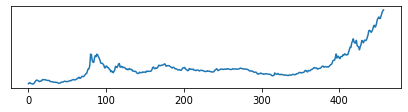

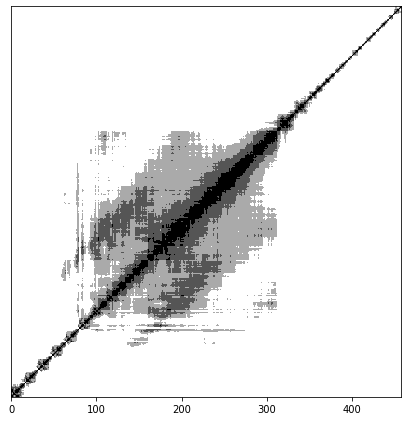

In [8]:
rec_plot(emb_serie_gold)

## Gráfico de recorrência da série do preço do bitcoin (bitc)

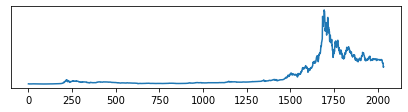

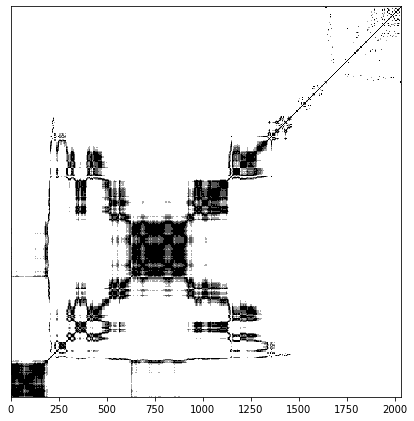

In [9]:
rec_plot(emb_serie_bitc, 30)

## Gráfico de recorrência da série do preço de uma cota da bovespa (bvsp)

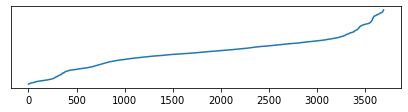

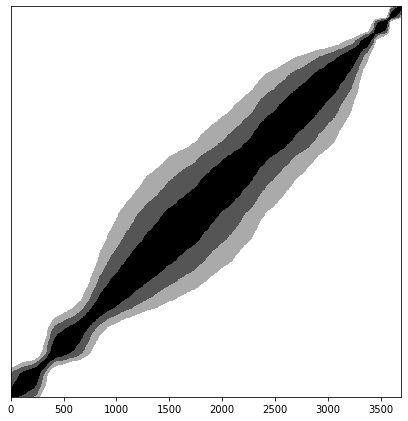

In [10]:
rec_plot(emb_serie_bvsp, eps=5000)

## Gráfico de recorrência da série do passeio aleatório (rand)

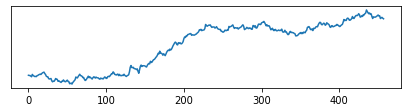

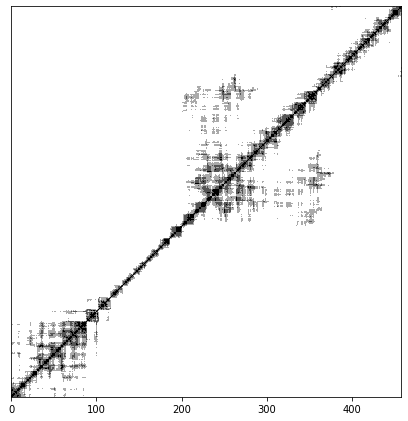

In [11]:
rec_plot(emb_serie_rand, eps=2)

# Reconstrução do Atrator

In [12]:
import src.animation_plot as anime_plot

### Atrator da série Golden USD

In [13]:
anime_plot.create_animation_3d(emb_serie_gold, gif_name="./img/emb_golden.gif", figsize=(6,6))
anime_plot.plot_animation(gif_name="../img/emb_golden.gif")

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


### Atrator da série Bovespa

In [ ]:
anime_plot.create_animation_3d(serie_bvsp, gif_name="./img/emb_bvsp.gif", figsize=(6,6), frames=100)
anime_plot.plot_animation(gif_name="../img/emb_bvsp.gif")

### Atrator da série Random Walk

In [14]:
anime_plot.create_animation_3d(emb_serie_rand, gif_name="./img/emb_randomwalk.gif", figsize=(6,6))
anime_plot.plot_animation(gif_name="../img/emb_randomwalk.gif")

MovieWriter imagemagick unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


## Cálculo do expoente de lyapunow em janelas de tamanho 30 (um mês)

In [21]:
def lyapunov_window(data, window_size=30):
    
    lyap = []
    for i in range(data.shape[1]):
        if i < window_size:
            lyap.append(np.nan)
        else:
            dists = nlts.distance_evolution(data[:,(i-50):i].T, 10)
            lyap.append(nlts.lyap_from_dist(dists, debug_plot=False))
            
    return np.array(lyap)

def lyapunov_window_plot(emb_serie, m, index=None, window_size=30):
    serie_df = pd.DataFrame(emb_serie.T, columns=['d%d'%(i+1) for i in range(m)])
    serie_df["lyapunov"] = lyapunov_window(emb_serie, window_size)
    serie_df["zero"] = 0
    serie_df["lyap_mean"] = serie_df["lyapunov"].mean()
    
    if index is not None:
        serie_df["date"] = index[:serie_df.shape[0]]
        serie_df.set_index('date')[['lyapunov', 'zero', 'lyap_mean']].iloc[window_size:].plot(figsize=(18,3))
        plt.show()
        serie_df.set_index('date')['d1'].iloc[window_size:].plot(figsize=(18,3))
        plt.show()
    else:
        serie_df[['lyapunov', 'zero', 'lyap_mean']].iloc[window_size:].plot(figsize=(18,3))
        plt.show()
        serie_df['d1'].iloc[window_size:].plot(figsize=(18,3))
        plt.show()
    

### Expoente de Lyapunov para a série do ouro

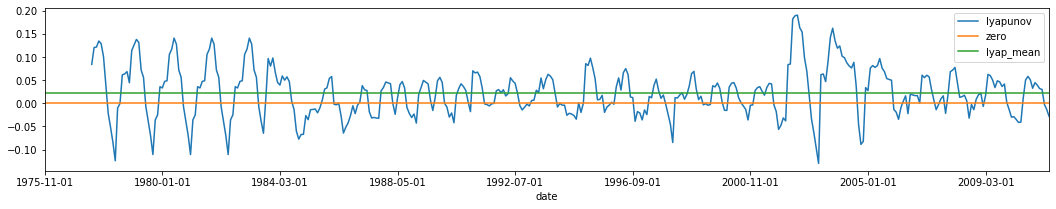

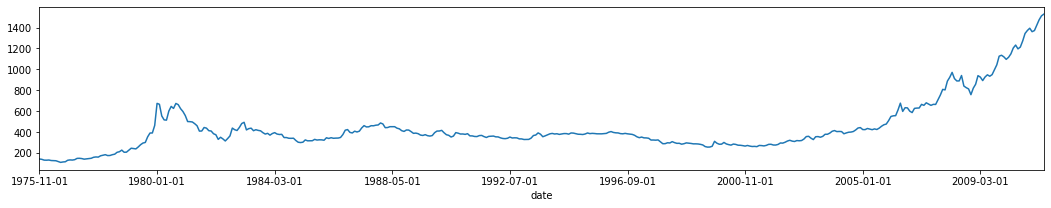

In [17]:
lyapunov_window_plot(emb_serie_gold, m1, index=gold_usd.date.values[:emb_serie_gold.shape[1]])

### Expoente de Lyapunov para a série do bitcoin

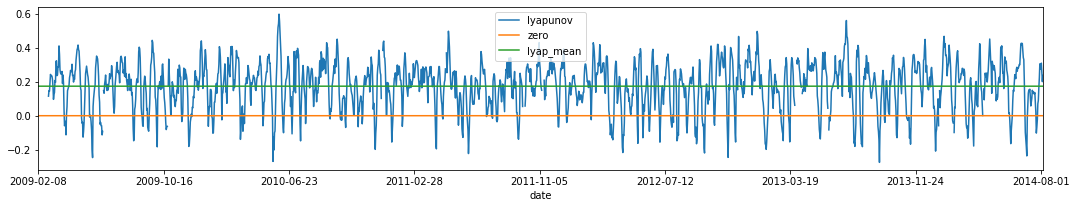

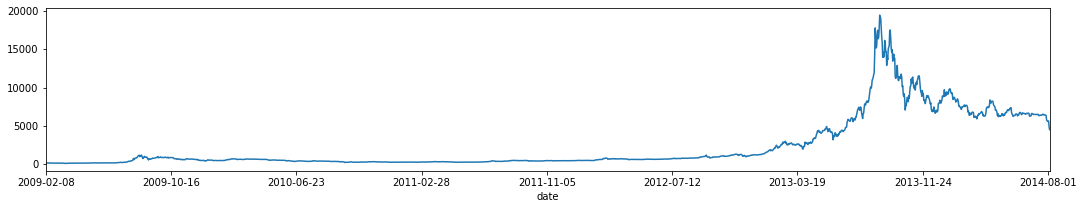

In [18]:
lyapunov_window_plot(emb_serie_bitc, m2, index=bitcoin_usd.date.values)

### Expoente de Lyapunov para a série da bovespa

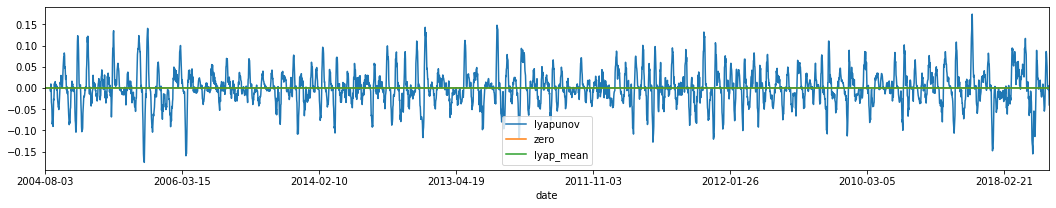

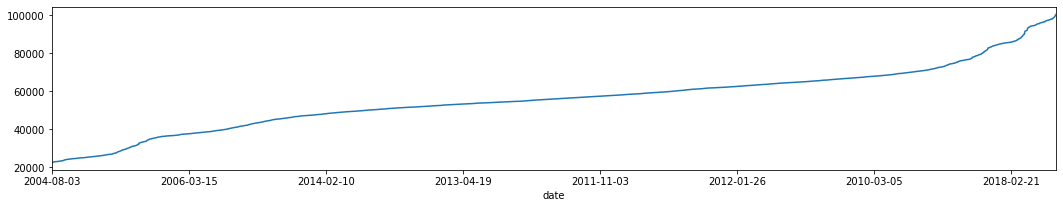

In [19]:
lyapunov_window_plot(emb_serie_bvsp, m3, index=bvsp.Date.values)

### Expoente de Lyapunov para a série do passeio aleatório

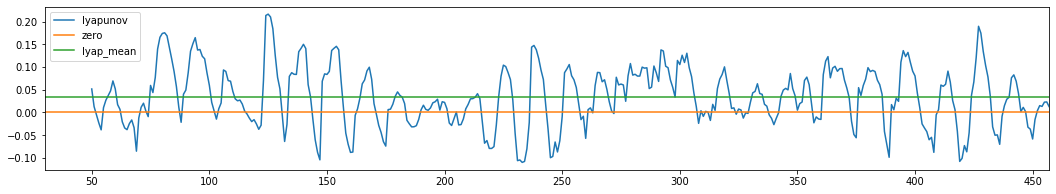

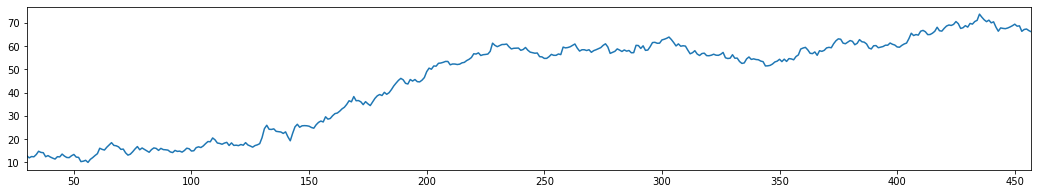

In [22]:
lyapunov_window_plot(emb_serie_rand, m4)